In [ ]:
!pip install langchain langchain-groq sentence-transformers networkx matplotlib spacy
!python -m spacy download en_core_web_sm

In [ ]:
!pip install langchain_huggingface

In [ ]:
!pip install langchain_community

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import userdata
import os
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

In [1]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [16]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [17]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name="llama-3.3-70b-versatile"
)

In [18]:
import networkx as nx
from langchain_community.document_loaders import TextLoader, DirectoryLoader

loader = DirectoryLoader(
    "/content/Marie Curie",
    glob="*.txt",
    loader_cls=TextLoader
)
docs = loader.load()

documents = [doc.page_content for doc in docs]

G = nx.Graph()

In [26]:
for doc_id, doc in enumerate(documents):
    doc_nlp = nlp(doc)
    entities = [ent.text for ent in doc_nlp.ents if ent.label_ in ["PERSON", "ORG", "GPE", "LOC", "EVENT", "WORK_OF_ART"]]


    doc_node = f"doc_{doc_id}"
    G.add_node(doc_node, text=doc, type="document")


    for entity in entities:
        if not G.has_node(entity):
            G.add_node(entity, type="entity")
        G.add_edge(doc_node, entity)

    for i, ent1 in enumerate(entities):
        for ent2 in entities[i+1:]:
            G.add_edge(ent1, ent2)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 39 nodes and 192 edges


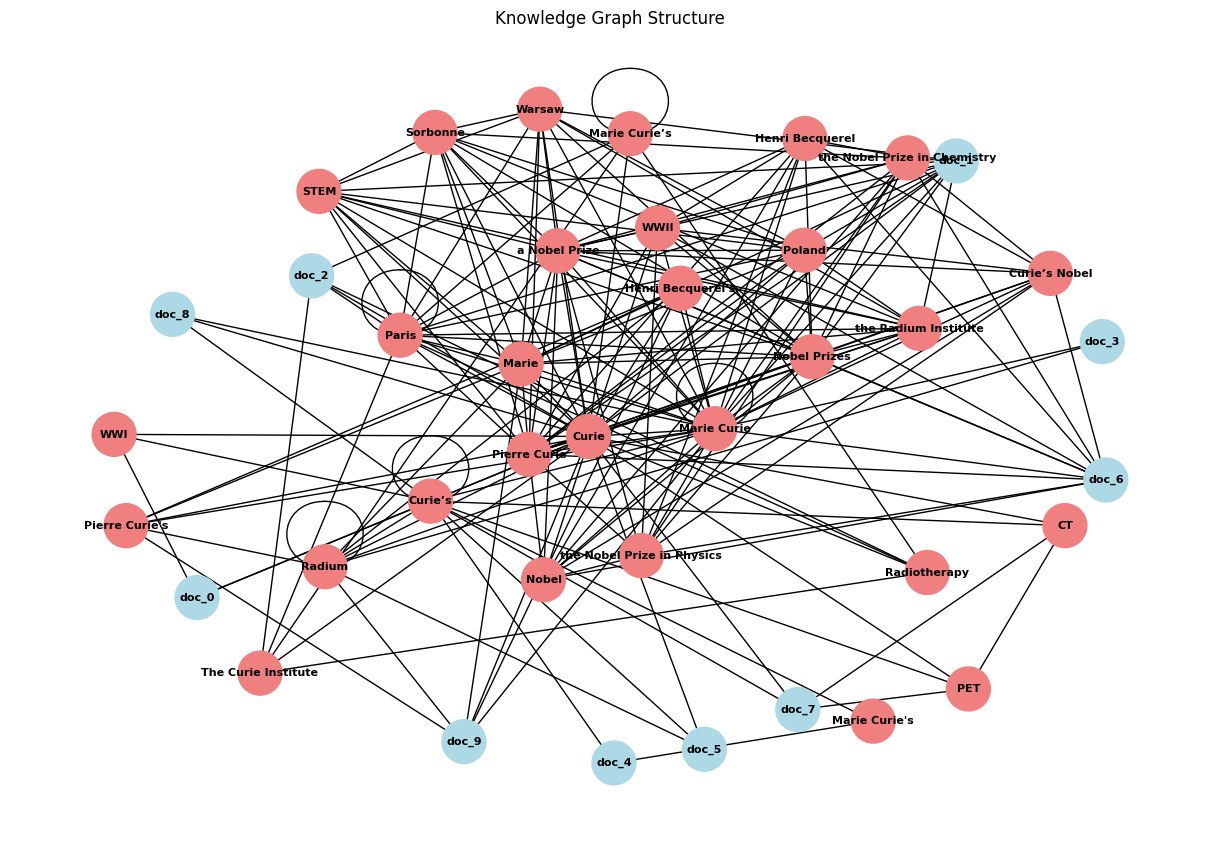

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2, iterations=50)

node_colors = ['lightblue' if G.nodes[node].get('type') == 'document' else 'lightcoral'
               for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_colors,
        node_size=1000, font_size=8, font_weight='bold')
plt.title("Knowledge Graph Structure")
plt.show()

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def graph_rag_query(query, top_k=3):
    query_embedding = embedding_model.encode([query])

    doc_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'document']
    doc_texts = [G.nodes[node]['text'] for node in doc_nodes]
    doc_embeddings = embedding_model.encode(doc_texts)

    similarities = cosine_similarity(query_embedding, doc_embeddings)[0]

    top_indices = np.argsort(similarities)[-top_k:][::-1]
    relevant_docs = []

    for idx in top_indices:
        doc_node = doc_nodes[idx]
        doc_text = G.nodes[doc_node]['text']

        connected_entities = [neighbor for neighbor in G.neighbors(doc_node)
                            if G.nodes[neighbor].get('type') == 'entity']

        relevant_docs.append({
            'text': doc_text,
            'entities': connected_entities,
            'similarity': similarities[idx]
        })

    return relevant_docs

In [29]:
from langchain.schema import HumanMessage

def generate_answer(query):
    relevant_docs = graph_rag_query(query)

    context_parts = []
    for doc in relevant_docs:
        entities_str = ", ".join(doc['entities']) if doc['entities'] else "No entities"
        context_parts.append(f"Document: {doc['text']}\nRelated entities: {entities_str}\n")

    context = "\n".join(context_parts)

    prompt = f"""Based on the following context from a knowledge graph, answer the question.

Context:
{context}

Question: {query}

Answer based on the relationships and entities in the context:"""

    response = llm.invoke([HumanMessage(content=prompt)])
    return response.content

query = "Who is MarieCurie?"
answer = generate_answer(query)
print(f"Query: {query}")
print(f"Answer: {answer}")

Query: Who is MarieCurie?
Answer: Marie Curie is a pioneering physicist and chemist, born in 1867 in Warsaw, Poland. She is the first woman to win a Nobel Prize and the only person to win Nobel Prizes in two different scientific fields (Physics and Chemistry). She is known for her groundbreaking research on radioactivity, her dedication to science, and her legacy in paving the way for women in STEM. She is also recognized for her contributions to healthcare, particularly in the development of diagnostic imaging, cancer treatment, and nuclear medicine. Related entities associated with her include her husband Pierre Curie, the Sorbonne, the Radium Institute, and the Nobel Prizes she won.


In [30]:
test_queries  = [
    "What was Marie Curie's most important discovery?",
    "Tell me about radioactivity research",
    "What awards did Marie Curie receive?"
]

for query in test_queries:
    print(f"\n{'='*150}")
    print(f"Query: {query}")
    print(f"Answer: {generate_answer(query)}")

    docs = graph_rag_query(query, top_k=2)
    print(f"\nRetrieved documents:")
    for i, doc in enumerate(docs, 1):
        print(f"{i}. {doc['text']} (similarity: {doc['similarity']:.3f})")


Query: What was Marie Curie's most important discovery?
Answer: Based on the context provided, Marie Curie's most important discovery was the discovery of radium and polonium, which led to a deeper understanding of radioactivity and transformed the field of chemistry. This discovery is highlighted in the first document, where it is mentioned that she won the Nobel Prize in Chemistry in 1911 for this achievement. Additionally, the second document explains how her discoveries redefined the field of chemistry, proving that atoms could emit energy and challenging the long-standing belief that atoms were indivisible.

The discovery of radium and polonium is closely related to the entities "Radium", "Polonium", and "Radioactivity" mentioned in the context. The context also highlights the significance of this discovery, stating that it "redefined the field of chemistry" and led to new branches of inorganic chemistry, nuclear reactions, and isotopic studies.

While the context does not provid